# **Занятие 2. Модели PyTorch**

https://vk.com/lambda_brain

Модели в машинном обучении реализуют концепцию прогноза, предсказания, в виде единой целостной сущности (класс, объект). Они же в прикладном плане служат основной для создания всех видов нейронных сетей.


---



##**Подготовка данных**

Для корректного продолжения работы в текущем ноутбуке требуется выполнить ряд инициализаций из предыдущего задания. Запустите следующий код, формирующий тестовые наборы даннх:

In [4]:
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.random.seed(42)
sz = 100
x = np.random.rand(sz, 1)
y = 1 + 2 * x + 0.1 * np.random.randn(sz, 1)
idx = np.arange(sz)
np.random.shuffle(idx)
sz80 = (int)(sz*0.8)
train_idx = idx[: sz80]
val_idx = idx[sz80:]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)



Модель PyTorch представляет собой обычный класс Python, унаследованный от класса **nn.Module**.

https://pytorch.org/docs/stable/nn.html?source=post_page---------------------------#torch.nn.Module

Самых важных методов, которые потребуется переопределить в нашей модели, два:

1) **стандартный конструктор**

В конструкторе задаются базовые атрибуты, в нашем случае это два параметра a и b. Они определяются в конструкторе с помощью специального типа nn.Parameter.

Количество атрибутов модели не ограничено.

2) **forward()**, непосредственно выполняющий все нужные вычисления на основании входных данных (они задаются как параметр этого метода).

Однако даже сами эти методы не потребуется вызывать напрямую. **В PyTorch "запускается" сама модель в целом**, и создание нужного объекта и вызов forward() происходят автоматически -- они так же скрыты под капотом.

Вот как будет выглядеть наша модель для линейной регрессии:


In [5]:
from torch import optim, nn

class ManualLinearRegression(nn.Module):

    def __init__(self):
        super().__init__()
        # два наших параметра a и b
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        # формула линейной регрессии
        return self.a + self.b * x

Тип nn.Parameter очень удобен тем, что мы можем автоматизировать многие моменты, связанные с обработкой параметров. Например метод parameters() позволяет организовать итерацию по всем параметрам модели, и даже по параметрам вложенных моделей, которые могут потребоваться для настройки оптимизатора (вместо того, чтобы формировать такой список параметров вручную).

Текущие значения всех параметров можно получить с помощью метода state_dict().


---



**Важно.** Все наши выборки надо располагать на том же девайсе, где мы размещаем и модель. Это необходимо из соображений эффективности. Напомню, что данные основных типов PyTorch загружаются на девайс методом to().



Наконец, нам ещё потребуется вызвать вручную метод модели **train()**, который на самом деле ничего не делает, а просто переводит модель в стандартный обучающий режим. Существует и ряд других режимов работы модели (например, верификация), поэтому данный флажок надо устанавливать явно.


In [6]:
torch.manual_seed(42)

# создаём модель
model = ManualLinearRegression().to(device)
print(model.state_dict())

lr = 0.1
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    model.train() # режим обучения

    yhat = model(x_train_tensor) # "запускаем" модель с входными данными

    loss = loss_fn(yhat, y_train_tensor)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


Получим такие результаты, фактически не отличающиеся от предыдущих версий программы:

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])

Теперь в основном коде мы вообще избавились от всех явных упоминаний параметров a и b! Чтобы изучить поведение любых других моделей, достаточно лишь сменить название класса ManualLinearRegression, причём это можно прозрачно автоматизировать.


---



##**Вложенные модели**

PyTorch -- очень мощный по своим возможностям фреймворк. Он создавался, когда в машинном обучении уже был накоплен немалый опыт, и поэтому воплотил многие сильные идеи, которые в других ML-фреймворках либо не реализованы, либо реализованы плохо или неудобно.

Казалось бы, мы ушли почти от всей ручной работы, и теперь работаем только с абстракцией модели, где задаём конкретную формулу прогноза и пару параметров, которые в этой формуле используются. Однако для большинства прогнозов можно воспользоваться уже готовыми моделями PyTorch.

В частности, за линейную регрессию отвечает модель Linear

https://pytorch.org/docs/stable/nn.html?source=post_page---------------------------#torch.nn.Linear


---




In [7]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

Вместо создания двух атрибутов линейной регрессии мы готовим в нашей модели всего один атрибут linear, который будет хранить вложенную модель Linear. В её конструкторе указываются два параметра -- количество наборов данных на входе и на выходе. И в том, и в другом случае их по одному: Linear(1, 1). А в методе forward() нашей модели мы просто "запускаем" вложенную модель Linear.

In [8]:
from torch import optim, nn

torch.manual_seed(42)

model = LayerLinearRegression().to(device)
print(model.state_dict())

lr = 0.1
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    model.train()
    yhat = model(x_train_tensor)
    loss = loss_fn(yhat, y_train_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())


OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])
OrderedDict([('linear.weight', tensor([[1.9690]])), ('linear.bias', tensor([1.0235]))])


##**Последовательные модели**

Пока мы использовали совсем простую модель в один шаг (слой) с помощью линейной регрессии, однако PyTorch активнее всего применяется для создания нейронных сетей, концепция которых довольно проста: есть наборы слоёв, каждый из которых это по сути функция над тензорами, и данные просто прогоняются через такую последовательность слоёв (выход одного слоя есть вход для следующего).

Такая схема поддерживается в PyTorch последовательной моделью (тип nn.Sequential). В конструкторе она получает серию моделей, которые внутри автоматически связываются в последовательность вычислений через входы-выходы.

https://pytorch.org/docs/stable/nn.html?source=post_page---------------------------#torch.nn.Sequential


---



В нашем случае мы используем всего один слой Linear, и соответствующая последовательная модель может быть сформирована так:

`model = nn.Sequential(nn.Linear(1, 1)).to(device)`

Таким образом, мы вообще полностью избавились от всех пользовательских формул и типов данных, полностью сконструировав наш оптимизационный алгоритм из готовых кубиков PyTorch!


---




##**Шаг обучения**

Давайте взгляем на наш код ещё раз. Мы уже обобщили использование оптимизатора, функции потерь и модели. Эта схема универсальная, она по сути никак не изменится, если мы захотим использовать другой оптимизатор, или другой лосс, или другие модели. Но тогда может быть и эту схему можно ещё более обобщить?

Напрашивается вариант, когда мы эти три сущности, а также метки и признаки, подаём в некоторый универсальный алгоритм просто как настроечные параметры. Такой универсальный алгоритм называется **шаг обучения**.


In [9]:
# шаг обучения
def make_train_step(model, loss_fn, optimizer):
    # Формируем функцию, которая выполнит один шаг обучения
    def train_step(x, y):
        # Переводим модель в режим обучения
        model.train()
        # Вычислаем прогноз
        yhat = model(x)
        # Считаем лосс
        loss = loss_fn(yhat, y)
        # Вычисляем градиенты
        loss.backward()
        # Обновляем параметры и обнуляем градиенты
        optimizer.step()
        optimizer.zero_grad()
        # Возвращаем лосс
        return loss.item()

    # Возвращаем функцию для вызова внутри цикла обучения
    return train_step

Используем этот алгоритм для нашего конкретного случая:

In [10]:

from torch import optim, nn

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

lr = 0.1
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

# создадим функцию на основе модели, лосса и оптимизатора
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    # Выполним очередной шаг обучения ...
    loss = train_step(x_train_tensor, y_train_tensor)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])
OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])


##**Датасеты (Datasets)**

Продолжим оптимизацию и генерализацию нашей и так уже весьма универсальной программы. Сейчас мы преобразовываем массивы NumPy в тензоры PyTorch, но возможно есть более общий подход к представлению данных?

В PyTorch работу с данными принято вести с помощью **датасетов (Dataset, набор данных)**, которые можно трактовать как **питоновские списки кортежей, где каждый кортеж задаёт одну точку** (признак, метку, ...).

В конструкторе класса Dataset мы можем задавать самые разные формы представления входных данных (списка кортежей), от двух тензоров до CSV-файлов, и т. п.

https://pytorch.org/docs/stable/data.html?source=post_page---------------------------#torch.utils.data.Dataset

Совсем не обязательно загружать в датасет сразу все данные -- ведь это могут быть обучающие выборки из десятков тысяч изображений. В таком случае их лучше загружать по прямому требованию программы. Для этого предназначен метод __get_item__(), который индексирует входной набор, позволяя обращаться к его элементам по индексам как к обычному массиву (по индексу возвращается соответствующий кортеж).

Метод __len__() возвращает количество элементов во всём датасете.


---



Подготовим класс для наших данных.


In [11]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        super().__init__()
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)


Исходные данные преобразуем из формата массивов NumPy.

In [12]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


Но зачем вообще нужен дополнительный класс, если мы просто используем два тензора?

Действительно, если наш датасет -- всего два тензора, то можно задействовать готовый класс PyTorch, который называется TensorDataset:

In [13]:
from torch.utils.data import TensorDataset
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


Обратите внимание, что сейчас мы не загружаем датасеты в GPU (не отправляем их на девайс), и по умолчанию они работают на обычном процессоре. Если обучающая выборка большая, то хранить её лучше в оперативной памяти компьютера, а не графической платы.

Но зачем всё же мы специально создаём датасеты? Потому что вместе с ними очень удобно использовать мощные загрузчики данных.


---

##**Загрузчик данных (DataLoader)**

Пока в нашем простеньком примере для пакетного градиентного спуска использовались все данные целиком. В реальных проектах так бывает редко -- обучающие выборки могут быть очень велики. Поэтому наш датасет надо научиться делить на более мелкие наборы, **мини-пакеты**.

В PyTorch для этого имеется специальный класс DataLoader

https://pytorch.org/docs/stable/data.html?source=post_page---------------------------#torch.utils.data.DataLoader

Идея его проста: мы задаём, какой набор данных использовать, какой желателен размер мини-пакета, и требуется ли данные этого мини-пакета перемешивать на каждой эпохе.




In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)


Загрузчик работает как итератор: мы просто запрашиваем у него очередную порцию данных.

Получать в цикле два очередных тензора с подвыборкой можно например так:

`for x_batch, y_batch in train_loader:`

Тогда новая версия нашей программы будет такая:


In [15]:
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]])), ('0.bias', tensor([1.0243]))])


Обратите внимание, что теперь мы явно посылаем наши мини-пакеты на девайс, где развёрнута модель, потому что, как говорилось выше, датасеты исходно создаются в оперативной памяти. В частности, когда используются большие фермы с множеством графических плат, можно распределять эти мини-пакеты по разным GPU.

И второе изменение -- добавился внутренний цикл, в котором мы последовательно получаем и обрабатываем кусочки исходной обучающей выборки.

Итак, теперь по сути мы можем полностью сфокусироваться на обучающей выборке. Мы создаём датасет и загрузчик данных для него. То же самое мы делаем и для тестовой выборки, которую мы формировали вручную.

Но нельзя ли автоматизировать и этот момент?


---

##**Случайное разделение выборки**

Именно для цели разделения выборки на обучающий и тестовый наборы в PyTorch имеется метод random_split(). Только, конечно, не надо забывать, что он исходно применяется ко всему входному массиву!

random_split() получает на вход исходный датасет и список из двух чисел, первое из которых задаёт (в процентах) размер обучающей выборки, а второе число -- размер тестовой выборки.



In [16]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

##**Оценка**

Заключительная часть посвящена оценке успешности нашей модели,
что можно сделать через расчёт лосса для тестовой выборки. Для этого нам надо добавить дополнительный цикл итераций по мини-пакетам уже не обучающей, а тестовой выборки, и отправить их на тот же девайс, где и модель.

Тут надо учеть два момента: во-первых, нам для этого уже не нужно считать градиенты, потому что выборка не обучающая, а тестовая (применяем упомянутый выше torch.no_grad() ко всему такому циклу), и во-вторых, модель надо явно перевести из обучающего режима в оценочный/тестовый с помощью метода eval().


In [17]:
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    # обучающая выборка
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)

    # тестовая выборка
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            val_loss = loss_fn(yhat, y_val)

print(model.state_dict())
print(loss, val_loss)

OrderedDict([('0.weight', tensor([[1.9586]])), ('0.bias', tensor([1.0195]))])
0.004001074004918337 tensor(0.0165)


##**Задание**

Оформите ваш код из последнего задания первого занятия так, чтобы он представлял собой работу с моделью.
Добавьте верификацию модели по тестовой выборке, как в последнем примере.


##**Итог**

В первых двух занятиях мы изучили почти все ключевые шаги, которые делаются в практических проектах на PyTorch при разработке и анализе моделей машинного обучения!

Далее мы будем рассматривать конкретные прикладные примеры и приёмы использования PyTorch с помощью нашей универсальной схемы.


12.373974800109863
4.637154579162598
2.293038845062256
1.3099160194396973
1.1675903797149658
tensor(1.8777)
2.0857715606689453
0.8957853317260742
0.9060989618301392
0.5528625249862671
0.5623985528945923
tensor(0.9368)
1.071160078048706
0.5751321315765381
0.7059354782104492
0.4494728446006775
0.4271671772003174
tensor(0.6683)
0.7795592546463013
0.4475248157978058
0.5520793199539185
0.3604928255081177
0.33005857467651367
tensor(0.5118)
0.6089280843734741
0.3544285297393799
0.4268190860748291
0.28517186641693115
0.25422903895378113
tensor(0.3988)
0.4842902719974518
0.2820499539375305
0.32904142141342163
0.2252984195947647
0.19567261636257172
tensor(0.3127)
0.38802623748779297
0.22537343204021454
0.25374796986579895
0.17855040729045868
0.15071600675582886
tensor(0.2463)
0.31258872151374817
0.1808997392654419
0.19604067504405975
0.14221927523612976
0.11630465090274811
tensor(0.1950)
0.2531920075416565
0.1459490805864334
0.15193231403827667
0.11401774734258652
0.09003031998872757
tensor(0.15

ValueError: x and y must have same first dimension, but have shapes (80, 1) and (20, 1)

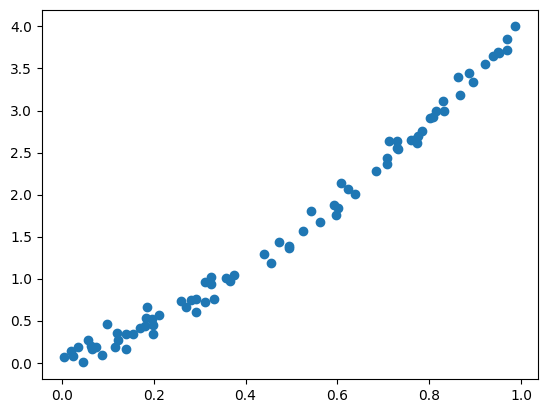

In [32]:
import torch
from torch import optim, nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


np.random.seed(42)
sz = 100
x = np.random.rand(sz, 1)
y = 2 * x ** 2 + 2 * x + 0.1 * np.random.randn(sz, 1)
idx = np.arange(sz)
np.random.shuffle(idx)
sz80 = (int)(sz*0.8)
train_idx = idx[: sz80]
val_idx = idx[sz80:]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
x_tensor = torch.from_numpy(x).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

train_data = TensorDataset(x_train_tensor, y_train_tensor)
dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)


class ManualLinearRegression(nn.Module):

    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.c = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        return self.a * x ** 2 + self.b * x + self.c


# создаём модель
model = ManualLinearRegression().to(device)

lr = 0.1
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

def make_train_step(model, loss_fn, optimizer):
    # Формируем функцию, которая выполнит один шаг обучения
    def train_step(x, y):
        # Переводим модель в режим обучения
        model.train()
        # Вычислаем прогноз
        yhat = model(x)
        # Считаем лосс
        loss = loss_fn(yhat, y)
        # Вычисляем градиенты
        loss.backward()
        # Обновляем параметры и обнуляем градиенты
        optimizer.step()
        optimizer.zero_grad()
        # Возвращаем лосс
        return loss.item()

    # Возвращаем функцию для вызова внутри цикла обучения
    return train_step

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    # обучающая выборка
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        print(loss)

    # тестовая выборка
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            val_loss = loss_fn(yhat, y_val)
            print(val_loss)

print(model.state_dict())
plt.scatter(x_train_tensor.detach(), y_train_tensor.detach(), label="Данные")
plt.plot(x_train_tensor.detach(), yhat.detach(), color='red', label="Модель")
plt.legend()
plt.title("Квадратичная регрессия")
plt.show()